In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cpu') # torch.device('cpu')
device

device(type='cpu')

In [3]:
rng = np.random.default_rng(73512)

# Dane syntetyczne

In [4]:
indices = np.arange(0, 50, 0.02)
synthetic_data = (np.sin(indices * 3) + indices / 10 + (indices / 10) ** 2 + np.sin(indices * 10)) #/ np.exp(indices / 20)

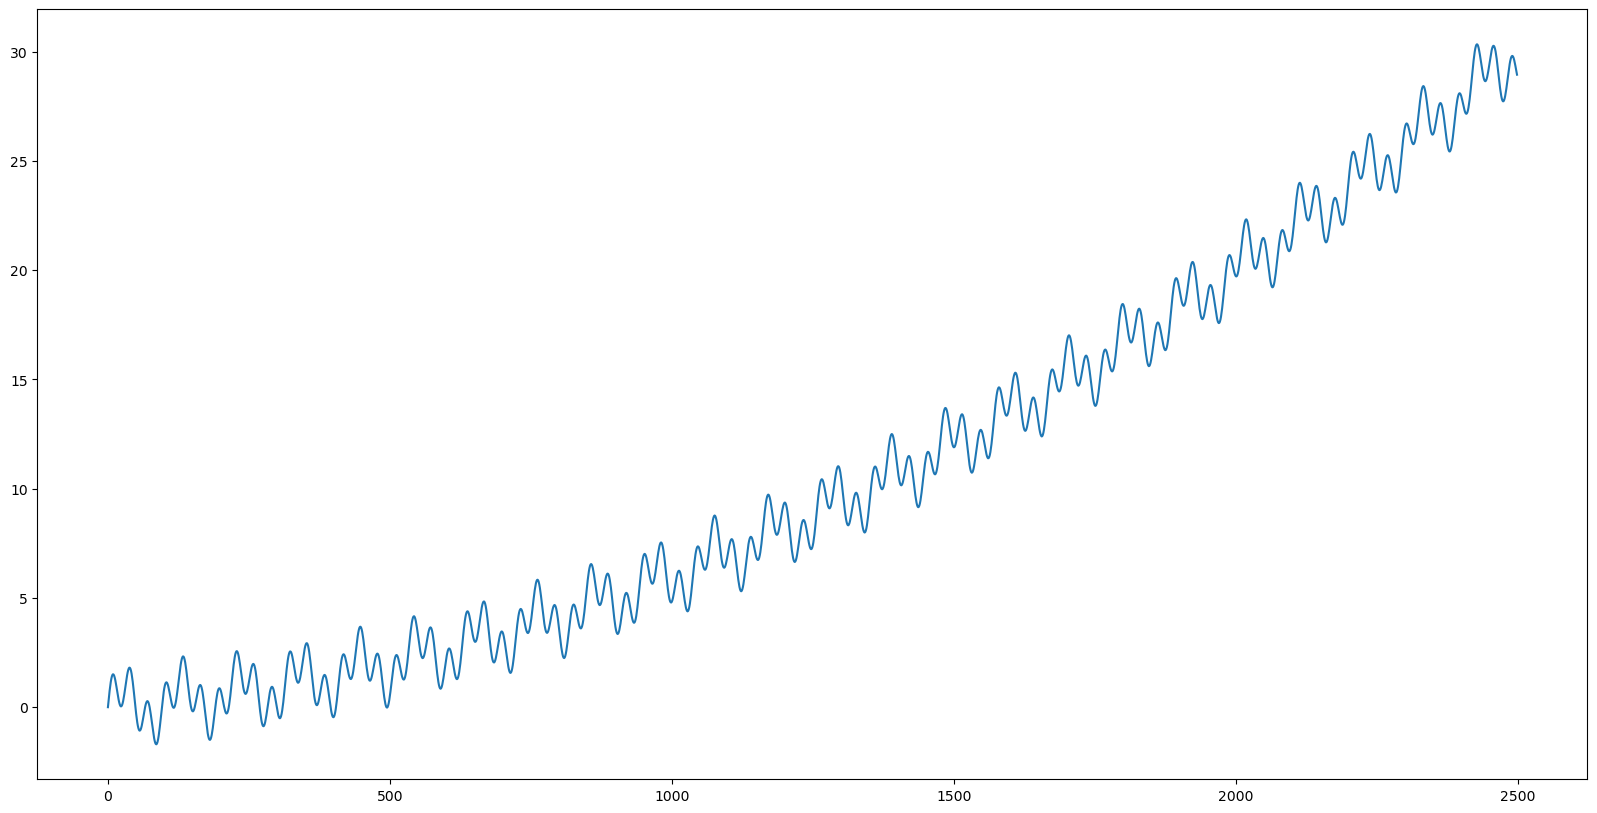

In [5]:
plt.figure(figsize=[20, 10])
plt.plot(synthetic_data)
plt.show()

In [6]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

In [7]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data) - sequence_len - 1):
    data_seq.append(torch.from_numpy(synthetic_data[i:i + sequence_len]))
    data_targets.append(synthetic_data[i + sequence_len + 1])

In [8]:
data = (torch.stack(data_seq).float() - min_value) / max_value
data_targets = (torch.Tensor(data_targets).float() - min_value) / max_value
train_indices = rng.random(len(data_seq)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [9]:
class SimpleRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [11]:
model.train() 

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0456
Epoch: 10, loss: 0.000551
Epoch: 20, loss: 0.000594
Epoch: 30, loss: 0.000424
Epoch: 40, loss: 0.000255
Epoch: 50, loss: 0.000121
Epoch: 60, loss: 7.75e-05
Epoch: 70, loss: 0.000371
Epoch: 80, loss: 9.57e-05
Epoch: 90, loss: 0.00013
Epoch: 100, loss: 4.34e-05


In [12]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0102)


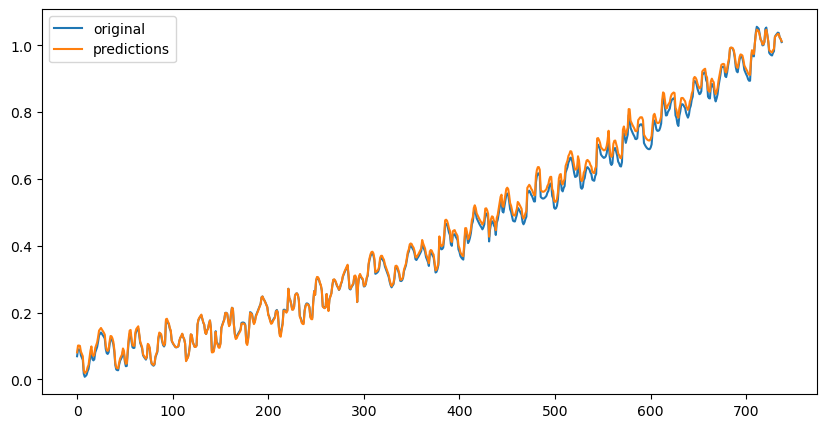

In [13]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Koniec laborki?

### Co poszło nie tak?

In [14]:
train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [15]:
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00188
Epoch: 10, loss: 0.000343
Epoch: 20, loss: 7.09e-05
Epoch: 30, loss: 0.000152
Epoch: 40, loss: 7.39e-05
Epoch: 50, loss: 0.00012
Epoch: 60, loss: 8.61e-05
Epoch: 70, loss: 7.75e-05
Epoch: 80, loss: 7.05e-05
Epoch: 90, loss: 6.36e-05
Epoch: 100, loss: 3.53e-05


In [16]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1310)


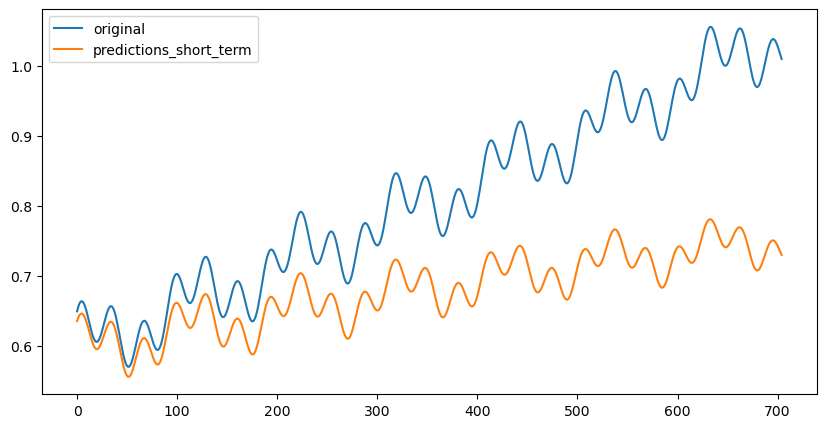

In [17]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions_short_term')
plt.legend()
plt.show()

# Sieć rekurencyjna

In [18]:
class RecurrentRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_state):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs + num_state, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear_out = nn.Linear(num_hidden, num_outputs)
        self.linear_state = nn.Linear(num_hidden, num_state)

    def forward(self, x, state):
        x = torch.cat([x, state], 1)
        x = self.linear1(x)
        x = self.act_fn(x)
        out = self.linear_out(x)
        state = self.linear_state(x)
        return out, state
    
model = RecurrentRegressor(1, 5, 1, 5).to(device)
model

RecurrentRegressor(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (linear_state): Linear(in_features=5, out_features=5, bias=True)
)

### Dokończ pętlę uczącą poniżej:

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x), 5).to(device)
        optimizer.zero_grad() 
        for i in range(x.size(1)):
            x_one = x[:, i].unsqueeze(1)
            if i < sequence_len - 1:
                target = x[:, i+1]
            else:
                target = targets
            preds, state = model(x_one, state)
            preds = preds.squeeze(dim=1)
            loss = loss_fun(preds, target)
            loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.547
Epoch: 10, loss: 0.058
Epoch: 20, loss: 0.0236
Epoch: 30, loss: 0.000846
Epoch: 40, loss: 0.000353
Epoch: 50, loss: 0.000224
Epoch: 60, loss: 0.000175
Epoch: 70, loss: 0.000161
Epoch: 80, loss: 0.000154
Epoch: 90, loss: 0.000136
Epoch: 100, loss: 0.000108


In [20]:
with torch.no_grad():
    state = torch.zeros(len(test_data), 5).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:, i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

tensor(0.0546)


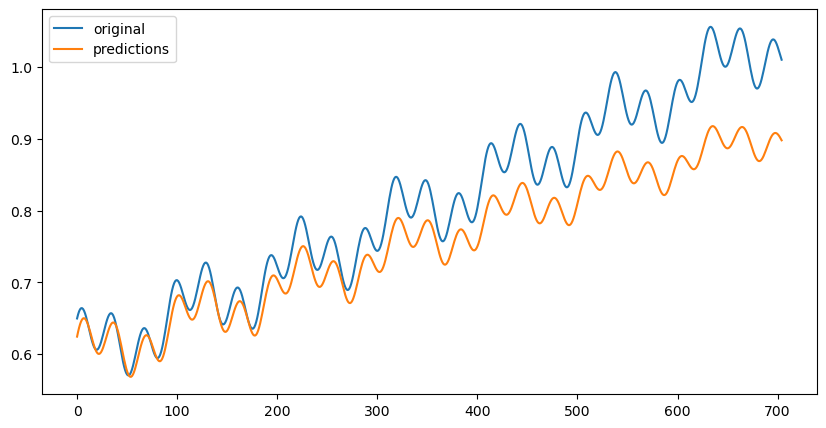

In [21]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

# Sieci rekurencyjne w Torchu

In [22]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False) #batch_first=False is default!!
rnn

RNN(3, 4, num_layers=2)

In [23]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = rnn(x, h0)
output
# ponizszy output to wszystkie stany sieci z sekwencji o dlugości 5

tensor([[[ 0.5177,  0.1980,  0.1202, -0.3895],
         [ 0.5422, -0.5689,  0.8346, -0.1114]],

        [[-0.3196,  0.7570, -0.1790, -0.5088],
         [-0.3574,  0.0730,  0.5889,  0.0178]],

        [[ 0.1159,  0.1250,  0.3901, -0.2871],
         [-0.0852,  0.1709,  0.3136, -0.3305]],

        [[-0.2753,  0.4664,  0.4428, -0.2397],
         [ 0.3346, -0.4004,  0.5639, -0.0797]],

        [[-0.0710, -0.1364,  0.4124, -0.0123],
         [-0.5596,  0.4552,  0.6665,  0.1543]]])

In [24]:
output[-1]
# ostatni stan zwrócony przez sieć rekurencyjną:

tensor([[-0.0710, -0.1364,  0.4124, -0.0123],
        [-0.5596,  0.4552,  0.6665,  0.1543]])

In [25]:
hn
# jak widać ostatni stan i output się pokrywają (czy tam na odwrót)

tensor([[[-0.1636, -0.2847, -0.1327,  0.8760],
         [ 0.7943, -0.2308,  0.7536,  0.5219]],

        [[-0.0710, -0.1364,  0.4124, -0.0123],
         [-0.5596,  0.4552,  0.6665,  0.1543]]])

In [26]:
class RNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.rnn(x, hidden)   # przepuszczamy wejście ze stanem przez sieć rekurencyjną
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = RNNRegressor(1, 5, 2, 1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0591
Epoch: 10, loss: 0.0644
Epoch: 20, loss: 0.000703
Epoch: 30, loss: 0.000461
Epoch: 40, loss: 0.000294
Epoch: 50, loss: 0.000196
Epoch: 60, loss: 0.000162
Epoch: 70, loss: 0.000135
Epoch: 80, loss: 9.84e-05
Epoch: 90, loss: 7.31e-05
Epoch: 100, loss: 6.18e-05


In [28]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.0833)


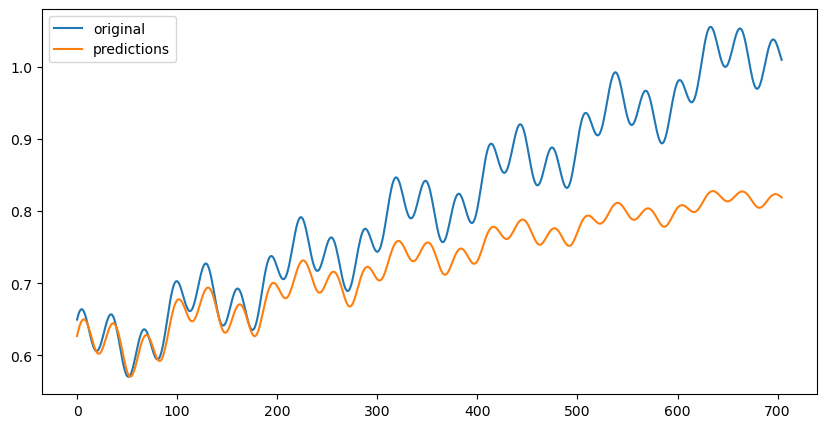

In [29]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Czy możemy jakoś rozdzielić krótką i długą pamięć?
T - tangens hiperboliczny

w tych dwóch obok siebie decydujemy co chcemy zapamiętać, a co mozemy zapomnieć
po prawej SS - decydujemy co chcemy zapamiętać do kolejnych iteracji

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

In [30]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, hidden_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

# ^ teraz musimy inicjować dwa stany a nie tylko jeden (stan ukryty i stan komórki, ale one mają takie same parametry)

In [31]:
print(output.size())
output
# wszystkie stany ukryte po drodze:

torch.Size([5, 3, 2])


tensor([[[-0.0859,  0.0113],
         [ 0.1293,  0.2302],
         [-0.2963, -0.3763]],

        [[-0.1327, -0.0416],
         [-0.0272,  0.2055],
         [-0.1896, -0.2418]],

        [[-0.1505, -0.0758],
         [-0.0925,  0.1506],
         [-0.1309, -0.0848]],

        [[-0.1601, -0.1013],
         [-0.0999,  0.1396],
         [-0.1447, -0.0785]],

        [[-0.1571, -0.1212],
         [-0.1223,  0.0462],
         [-0.1438, -0.0938]]], grad_fn=<StackBackward0>)

In [32]:
print(hn)
print(cn)

tensor([[[-0.1571, -0.1212],
         [-0.1223,  0.0462],
         [-0.1438, -0.0938]]], grad_fn=<StackBackward0>)
tensor([[[-0.4172, -0.4796],
         [-0.3206,  0.1443],
         [-0.3791, -0.3261]]], grad_fn=<StackBackward0>)


In [33]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1, 20, 2, 1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00102
Epoch: 10, loss: 0.000823
Epoch: 20, loss: 0.000524
Epoch: 30, loss: 0.000353
Epoch: 40, loss: 0.000216
Epoch: 50, loss: 7.04e-05
Epoch: 60, loss: 3.31e-05
Epoch: 70, loss: 2.2e-05
Epoch: 80, loss: 1.01e-05
Epoch: 90, loss: 1.19e-05
Epoch: 100, loss: 1.86e-05


In [35]:
with torch.no_grad():
    hidden, state = model.init_hidden(test_data.size(0))
    hidden, state = hidden.to(device), state.to(device) 
    test_preds, _ = model(test_data.to(device).unsqueeze(2), (hidden, state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.03563282638788223


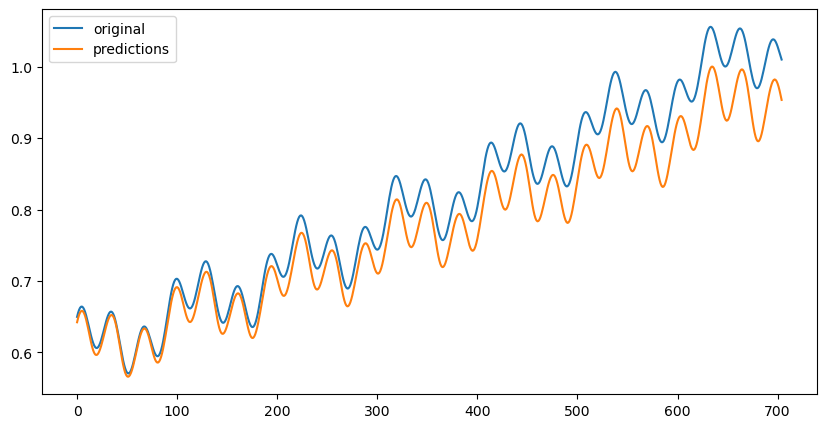

In [36]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()
# teraz trendy tej funkcji są duzo lepiej wychwytywane (dzięki pamięci długotrwałej)

### Mini zadanie: Jak wyglądałyby predykcje w oparciu o poprzednie predykcje?

In [ ]:
# TODO: kod
# róznica między uzywaniem tylko short_term, a long_term+short_term

# Predykcja Sequence to sequence

In [38]:
stock_price = pd.read_csv("https://www.galera.ii.pw.edu.pl/~kdeja/data/all_stocks_5yr.csv")

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)>

In [ ]:
mastercard_stock = stock_price[stock_price.Name=="MA"].open.values
visa_stock = stock_price[stock_price.Name=="V"].open.values

In [ ]:
# jak widać trend mastercard i visa jest podobny, więc moze sie uda przewidywać cenę jednych na podstawie cen drugich
plt.figure(figsize=[10, 5])
plt.plot(mastercard_stock, label='mastercard')
plt.plot(visa_stock, label='visa')
plt.legend()
plt.show()

In [ ]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

In [ ]:
data_seq = []
data_targets = []
sequence_len = 50
# na podstawie 50 cen akcji mastercard będziemy chciali przewidzieć 50 cen akcji visy
for i in range(len(mastercard_stock) - sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i:i + sequence_len]))
    data_targets.append(torch.from_numpy(visa_stock[i:i + sequence_len]))
    
data = (torch.stack(data_seq).float() - m_min_value) / m_max_value
data_targets = (torch.stack(data_targets).float() - v_min_value) / v_max_value    

train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [ ]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
projection_size = 1

lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, proj_size=projection_size)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, projection_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [ ]:
output

In [ ]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size=out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 50, 2, 1).to(device)
model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

In [ ]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0, len(test_targets), sequence_len):
        hidden, state = model.init_hidden(1)    # analizujemy stany ukryte
        hidden, state = hidden.to(device), state.to(device) 
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state))  # generujemy 50 przewidywanych wartości
        preds.append(pred.squeeze())     # dodajemy przewidziane wartości

In [ ]:
# co 50 są ziwne skoki, bo co 50 zerujemy stan
plt.figure(figsize=[10, 5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label='original')
plt.plot(torch.cat(preds).cpu().numpy(), label='predicted')
plt.legend()
plt.show()

### Co się stało, skąd takie dziwne predykcje?

In [ ]:
# przenosimy inicjalizację stanu ponad pętle

# TODO: mniej więcej tak jak ponizej, ale coś tam inaczej
with torch.no_grad():
    selected_test_targets = []
    preds = []
    hidden, state = model.init_hidden(1)    # analizujemy stany ukryte
    hidden, state = hidden.to(device), state.to(device) 
    for i in range(0, len(test_targets), sequence_len):
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state))  # generujemy 50 przewidywanych wartości
        preds.append(pred.squeeze())     # dodajemy przewidziane wartości

# Klasyfikacja serii
tymi sieciami mozna na przyklad klasyfikować gatunek muzyczny utworów na podstawie ich przebiegu

In [ ]:
libras = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data", header=None)

In [ ]:
libras.head()

In [ ]:
classes = libras[90].values
data = libras.values[:, :-1]

In [ ]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = rng.random(len(data)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

### Napisz klasyfikator

dwukierunkowość (self.bidirectional) - przetwarzamy sekwencję zarówno wprzód jak i w tył (mamy informacje o kontekście za nami jak i przed nami)

# Dane o różnej długości
- próbki mogą mieć rózne długości (np. właśnie utwory muzyczne)
- przyda się do realizacji miniprojektu

In [39]:
# tworzymy prosty zbiór danych:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [40]:
# na podstawie danych wejściowych będziemy chcieli przewidycwać accumulative sum (np. 1 2 3 -> 1 3 6)
min_gen_val = 10
max_gen_val = 1001
samples = 1000
max_gen_len = 32

data = []
targets = []
max_val = -1
for _ in range(samples):
    seq_len = rng.integers(low=1, high=max_gen_len, size=1)
    data_in = rng.integers(low=min_gen_val, high=max_gen_val, size=seq_len)
    data_sum = np.array([data_in[:i + 1].sum() for i in range(len(data_in))])
    data.append(torch.from_numpy(data_in))
    targets.append(torch.from_numpy(data_sum))
    max_val = data_sum[-1] if data_sum[-1] > max_val else max_val

In [41]:
# normalizacja zbioru i przygotowanie train_set i test_set
train_indices = int(len(data) * 0.7)
data = [(x / max_val).float() for x in data]
targets = [(x / max_val).float() for x in targets]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [42]:
# padding (wyrównywanie) - jak mamy sekwencje o róznej długości, to te o krótszej długości dopełniamy na jakąś długość, tak aby dopełnienie nie miało wpływu na zbiór danych (np. 0)
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0): # taką funkcję do paddowania moemy podać do dataloadera jako parametr collate_fn=
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens   # zwracamy te oryginalne długości wypadowanych tensorów

In [43]:
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [44]:
print(len(train_set[0][0]))
print(len(train_set[1][0]))

1
27


In [45]:
next(iter(train_loader)) # na końcu widzimy wartości spadowane, a nizej widzimy tensor z dlugosciami (oryginalnych x, a póxniej oryginalnych y)

(tensor([[0.0474, 0.0518, 0.0011,  ..., 0.0000, 0.0000, 0.0000],
         [0.0192, 0.0478, 0.0434,  ..., 0.0000, 0.0000, 0.0000],
         [0.0092, 0.0393, 0.0057,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0320, 0.0019, 0.0327,  ..., 0.0000, 0.0000, 0.0000],
         [0.0430, 0.0076, 0.0521,  ..., 0.0000, 0.0000, 0.0000],
         [0.0177, 0.0260, 0.0073,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0474, 0.0992, 0.1003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0192, 0.0670, 0.1104,  ..., 0.0000, 0.0000, 0.0000],
         [0.0092, 0.0485, 0.0542,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0320, 0.0338, 0.0665,  ..., 0.0000, 0.0000, 0.0000],
         [0.0430, 0.0506, 0.1027,  ..., 0.0000, 0.0000, 0.0000],
         [0.0177, 0.0437, 0.0509,  ..., 0.0000, 0.0000, 0.0000]]),
 [4,
  12,
  5,
  10,
  3,
  20,
  21,
  24,
  27,
  5,
  6,
  1,
  17,
  15,
  31,
  5,
  15,
  11,
  10,
  9,
  5,
  10,
  16,
  11,
  2,
  12,
  17,
  22,
  10,
  13,
  30,
  25,
  24,


In [46]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size = out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        # all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 200, 1, 1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 200, proj_size=1)
)

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        
        x = torch.transpose(x, 0, 1)
        preds, _ = model(x, (hidden, state))
        preds = torch.transpose(preds, 0, 1)
        
        # ponizej: pierwszy zamienia zpackowaną sekwencję na spaddowany tensor, a trzeci na odwrót
        # co daje zastosowanie zpakowanych sekwencji: np. jedna sekwencja o długości 7 a druga o 21, to w tym pierwszym będziemy mieli duzo zer i niepotrzebnie siec to będzie przetwarzać.
        # enforce_sorted=False, dostaniemy błąd jeśli sekwencje nie są posortowane względem długości (bo jak damy posortowane to jesteśmy w stanie szybciej przetworzyć te dane, czyli wytrenować model)
        # x - spadowany tensor
        # x_len - oryginalne długości
#         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        optimizer.zero_grad()
        # opcje optymalizacji - stosujemy maskę (ponizej:)
        # nie zastosowanie takiej maski moze pogorszyc wynik, nie zawsze tak jest ale jest to zalecane
        mask = targets != pad
        loss = loss_fun(preds[mask], targets[mask])
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0556
Epoch: 10, loss: 0.00981
Epoch: 20, loss: 0.00258
Epoch: 30, loss: 0.00116
Epoch: 40, loss: 0.000784
Epoch: 50, loss: 0.000765
Epoch: 60, loss: 0.000465
Epoch: 70, loss: 0.000266
Epoch: 80, loss: 0.000115
Epoch: 90, loss: 5.37e-05
Epoch: 100, loss: 1.67e-05


In [48]:
with torch.no_grad():
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)

#         x = torch.transpose(x, 0, 1)        
#         preds, _ = model(x, (hidden, state))
#         preds = torch.transpose(preds, 0, 1)
        
        x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        preds_packed, _ = model(x_packed, (hidden, state))
        preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        mask_tgt = targets != pad
        print(targets)
        print(preds)
        print(torch.abs(preds[mask_tgt] - targets[mask_tgt]).mean())
        print()

tensor([[0.0232, 0.0421, 0.0812,  ..., 0.0000, 0.0000, 0.0000],
        [0.0150, 0.0300, 0.0516,  ..., 0.6957, 0.7368, 0.0000],
        [0.0174, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0412, 0.0681, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0346, 0.0546,  ..., 0.0000, 0.0000, 0.0000],
        [0.0456, 0.0914, 0.1070,  ..., 0.8918, 0.0000, 0.0000]])
tensor([[0.0223, 0.0417, 0.0806,  ..., 0.0000, 0.0000, 0.0000],
        [0.0148, 0.0307, 0.0535,  ..., 0.7060, 0.7481, 0.0000],
        [0.0170, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0387, 0.0652, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0020, 0.0355, 0.0565,  ..., 0.0000, 0.0000, 0.0000],
        [0.0427, 0.0868, 0.1027,  ..., 0.9005, 0.0000, 0.0000]])
tensor(0.0034)

tensor([[0.0388, 0.0483, 0.0917,  ..., 0.0000, 0.0000, 0.0000],
        [0.0484, 0.0642, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0027, 0.0140,  ..., 0.0000, 0.0000, 0.000